# Target and Feature Columns

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_loc = 'data'

In [3]:
df_og = pd.read_pickle(f"{data_loc}/ml_dataset.pkl")
df_og['ethnicity'] = df_og['ethnicity'].str.lower().str.replace(' ','_')
# dropna, not supported by ML
df_og = df_og.dropna(subset=['sentiment_score_t','sentiment_score', 'imdb_score', 'ethnicity'])

In [4]:
df_og = df_og.merge(pd.get_dummies(df_og['ethnicity']), left_index=True, right_index=True)

In [5]:
unwanted_cols = [
    'id', 'imdb_score', 'sentiment_t', 'sentiment', 
    'imdb_score','tmdb_score','imdb_votes','tmdb_popularity', 
    'potential_seasons_left', 'recommended_min_age_viewership'
]

In [6]:
target_col = 'imdb_score'
feature_cols = df_og.select_dtypes([float, int, 'uint8']).columns

# errors raised are of columns that are not float/int. ID, sentiment_t, sentiment
feature_cols = feature_cols.drop(unwanted_cols, errors='ignore')

# ML Setup

In [7]:
X = df_og[feature_cols]
y = df_og[target_col]

In [8]:
X.isna().sum()[X.isna().sum()>0]

Series([], dtype: int64)

No NaNs confirmed

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# Ensemble Methods
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor # fits regression tree on neg gradient of loss functions
from sklearn.ensemble import AdaBoostRegressor # fit weak estimators on repeatedly modified versions of data, weigh them
from sklearn.ensemble import VotingRegressor # combine equally well performing models to balance out weaknesses
from sklearn.ensemble import StackingRegressor # uses output of individual estimators as input for new model

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69, shuffle=True, test_size=0.2)

## Testing with Regression Models

In [13]:
def train_test_predict_score(model):
    m = model()
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"""Results:
    MSE: {mse}
    RMSE: {rmse}
    R2: {r2}
    """)

In [126]:
%%time
train_test_predict_score(LinearRegression)

Results:
    MSE: 0.7747434969039734
    RMSE: 0.8801951470577268
    R2: 0.35051128324389935
    
CPU times: user 8min 37s, sys: 14min 3s, total: 22min 40s
Wall time: 2min 24s


In [14]:
%%time
train_test_predict_score(SVR)

Results:
    MSE: 1.1640308635157262
    RMSE: 1.0789026200337666
    R2: 0.024161009636675557
    
CPU times: user 6min 49s, sys: 0 ns, total: 6min 49s
Wall time: 6min 49s


In [128]:
%%time
train_test_predict_score(DecisionTreeRegressor)

Results:
    MSE: 0.01414480917229464
    RMSE: 0.11893195185607036
    R2: 0.9881420186232137
    
CPU times: user 520 ms, sys: 0 ns, total: 520 ms
Wall time: 517 ms


In [15]:
%%time
train_test_predict_score(RandomForestRegressor)

Results:
    MSE: 0.012014282786241566
    RMSE: 0.10960968381599122
    R2: 0.9899280973112213
    
CPU times: user 33.4 s, sys: 0 ns, total: 33.4 s
Wall time: 33.4 s


## Random Forest Regressor and GridSearch

In [13]:
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.pipeline import Pipeline # For setting up pipeline
# Various pre-processing steps
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler
from sklearn.model_selection import GridSearchCV # For optimization

In [14]:
%%time
pipe = Pipeline([
#    ('pca', PCA(n_components = 4)),
    ('scaler', StandardScaler()),
    ('selector', VarianceThreshold()),
    ('regressor', RandomForestRegressor())
], verbose=False)
pipe.fit(X_train, y_train)
train_score = pipe.score(X_train, y_train)
test_score = pipe.score(X_test, y_test)

print(f"Training set score: {train_score}")
print(f"Testing set score: {test_score}")

Training set score: 0.998300455765183
Testing set score: 0.9897347730436775
CPU times: user 42.2 s, sys: 0 ns, total: 42.2 s
Wall time: 43.1 s


Number of trees, t
Size of Sample, n (Total - N)
Number of variable to sample at each node, m (Total - M)

In [15]:
%%time
parameters = {
    'scaler': [
        StandardScaler(), MinMaxScaler(),
        Normalizer(), MaxAbsScaler()
    ],
    'selector__threshold': [0, 0.1],
    'regressor__n_estimators': [100, 500],
    'regressor__min_samples_split': [2, 10],
    'regressor__oob_score': [True],
    'regressor__max_samples': [25467, 25467/3]
}

CPU times: user 26 µs, sys: 0 ns, total: 26 µs
Wall time: 28.8 µs


In [16]:
%%time
grid = GridSearchCV(pipe, parameters, cv=2).fit(X_train, y_train)

/home/jupyter-pomkos/.conda/envs/data_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jupyter-pomkos/.conda/envs/data_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jupyter-pomkos/.conda/envs/data_env/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/jupyter-pomkos/.conda/envs/data_env/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/jupyter-pomkos/.conda/envs/data_env/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/jupyter-pomkos/.con

CPU times: user 36min 2s, sys: 3.32 s, total: 36min 6s
Wall time: 36min 4s


CPU times: user 47min 7s, sys: 14.7 s, total: 47min 22s

Wall time: 50min 2s

In [17]:
train_score = grid.score(X_train, y_train)
test_score = grid.score(X_test, y_test)

print(f'Training set score: {train_score:.2f}')
print(f'Test set score: {test_score:.2f}')

Training set score: 0.99
Test set score: 0.98


In [56]:
grid.n_splits_


2

In [28]:
cv_results = pd.DataFrame().from_dict(grid.cv_results_)
cv_results.head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_samples,param_regressor__min_samples_split,param_regressor__n_estimators,param_regressor__oob_score,param_scaler,param_selector__threshold,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,15.804007,0.161640,0.667725,0.004689,29289,2,100,True,StandardScaler(),0,"{'regressor__max_samples': 29289, 'regressor__...",0.967335,0.965214,0.966274,0.001061,8
1,15.803761,0.237395,0.667496,0.007006,29289,2,100,True,StandardScaler(),0.1,"{'regressor__max_samples': 29289, 'regressor__...",0.967735,0.964459,0.966097,0.001638,9
2,15.774039,0.269291,0.657347,0.003142,29289,2,100,True,MinMaxScaler(),0,"{'regressor__max_samples': 29289, 'regressor__...",0.967342,0.964692,0.966017,0.001325,10
3,0.935154,0.009286,0.185361,0.001126,29289,2,100,True,MinMaxScaler(),0.1,"{'regressor__max_samples': 29289, 'regressor__...",0.160758,0.159603,0.160181,0.000577,22


In [43]:
cv_results = cv_results.sort_values('mean_test_score', ascending=False)

In [44]:
cv_results[cv_results['param_regressor__n_estimators']==500]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_samples,param_regressor__min_samples_split,param_regressor__n_estimators,param_regressor__oob_score,param_scaler,param_selector__threshold,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
12,118.866914,5.937709,3.272714,0.009993,29289,2,500,True,Normalizer(),0,"{'regressor__max_samples': 29289, 'regressor__...",0.969541,0.965663,0.967602,0.001939,1
14,120.961061,29.718470,3.910170,0.583965,29289,2,500,True,MaxAbsScaler(),0,"{'regressor__max_samples': 29289, 'regressor__...",0.968264,0.965685,0.966974,0.001289,3
10,78.544074,0.101841,3.198063,0.018332,29289,2,500,True,MinMaxScaler(),0,"{'regressor__max_samples': 29289, 'regressor__...",0.968434,0.965440,0.966937,0.001497,4
9,79.279288,0.373760,3.239543,0.026655,29289,2,500,True,StandardScaler(),0.1,"{'regressor__max_samples': 29289, 'regressor__...",0.968230,0.965462,0.966846,0.001384,5


In [51]:
grid.best_score_

0.96760235376249

In [46]:
best_estim = grid.best_estimator_

Using the best parameters:

In [ ]:
RandomForestRegressor()

In [47]:
%%time
best_estim.fit(X_train, y_train)
train_score = best_estim.score(X_train, y_train)
test_score = best_estim.score(X_test, y_test)

print(f"Training set score: {train_score:.2f}")
print(f"Testing set score: {test_score:.2f}")

Training set score: 0.99
Testing set score: 0.98
CPU times: user 2min 50s, sys: 130 ms, total: 2min 50s
Wall time: 2min 50s


In [50]:
from joblib import dump, load
dump(best_estim, 'netflix_rfr_model.joblib') 

['netflix_rfr_model.joblib']

In [38]:
from joblib import dump, load
pipe = load('netflix_rfr_model.joblib')

Text(16.424999999999997, 0.5, 'Predicted IMDB score')

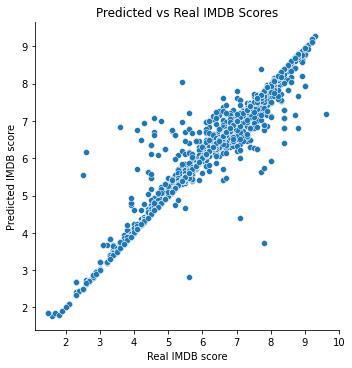

In [43]:
y_predict = pipe.predict(X_test)

sns.relplot(x=y_test, y=y_predict, kind='scatter')
plt.title('Predicted vs Real IMDB Scores')
plt.xlabel('Real IMDB score')
plt.ylabel('Predicted IMDB score')

## Features Used

In [65]:
features = list(X.columns)
selected_features = list()

for feature_list_index in pipe['selector'].get_support(indices=True):
    selected_features.append(features[feature_list_index])

In [84]:
rfr = pipe['regressor']
rfr.oob_score_

0.9829305145513038

In [69]:
features_df = pd.DataFrame()
features_df['features'] = selected_features
features_df['importance'] = pipe['regressor'].feature_importances_ # the higher the more important

In [82]:
features_df.sort_values('importance', ascending=False).iloc[0:25,:].sum()

features      release_yearsentiment_scoreseasonspotential_se...
importance                                             0.901283
dtype: object

The first 25 features, sorted by importance, make up 90% importance in determining the predicted IMDB score

In [83]:
features_df.sort_values('importance', ascending=False).iloc[0:25,:]

,features,importance
0,release_year,0.181509
127,sentiment_score,0.102587
2,seasons,0.099874
128,potential_seasons,0.066993
1,runtime,0.064938
7,documentation,0.045766
8,drama,0.044349
119,US,0.036061
5,comedy,0.031506
129,sentiment_score_t,0.023718


In [85]:
X

,release_year,runtime,seasons,action,animation,comedy,crime,documentation,drama,european,...,UY,VA,VE,VN,XX,ZA,ZW,sentiment_score,potential_seasons,sentiment_score_t
1,1976,113,0.0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,-0.132727,46,0.00000
2,1976,113,0.0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,-0.132727,46,0.00000
3,1976,113,0.0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,-0.132727,46,0.00000
4,1976,113,0.0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,-0.132727,46,0.00000
5,1976,113,0.0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,-0.132727,46,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77580,2021,116,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.125000,1,0.00000
77581,2021,116,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.125000,1,0.00000
77582,2021,116,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.125000,1,0.00000
77583,2021,116,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.125000,1,0.00000
